# **Paper Information**

The paper that was implemented is "Diff-Retinex: Rethinking Low-light Image Enhancement with A Generative
Diffusion Model".

It could be found at: https://arxiv.org/pdf/2308.13164

Code Authors: Hamza Etçibaşı, Enes Şanlı

# **Paper Summary**

Diff-Retinex is a physically explainable and generative diffusion model for low-light image enhancement. It rethinks the low-light image enhancement task by integrating the advantages of the physical model and the generative network. The Retinex model decomposes the image into illumination and reflectance images, and the generative diffusion model enhances the illumination image while preserving the reflectance image. This results in enhanced images that are both brighter and more realistic.

Diff-Retinex is shown to be effective on a variety of real-world low-light datasets, and it outperforms state-of-the-art methods both qualitatively and quantitatively. It is also shown to be generalizable to a variety of low-light conditions.

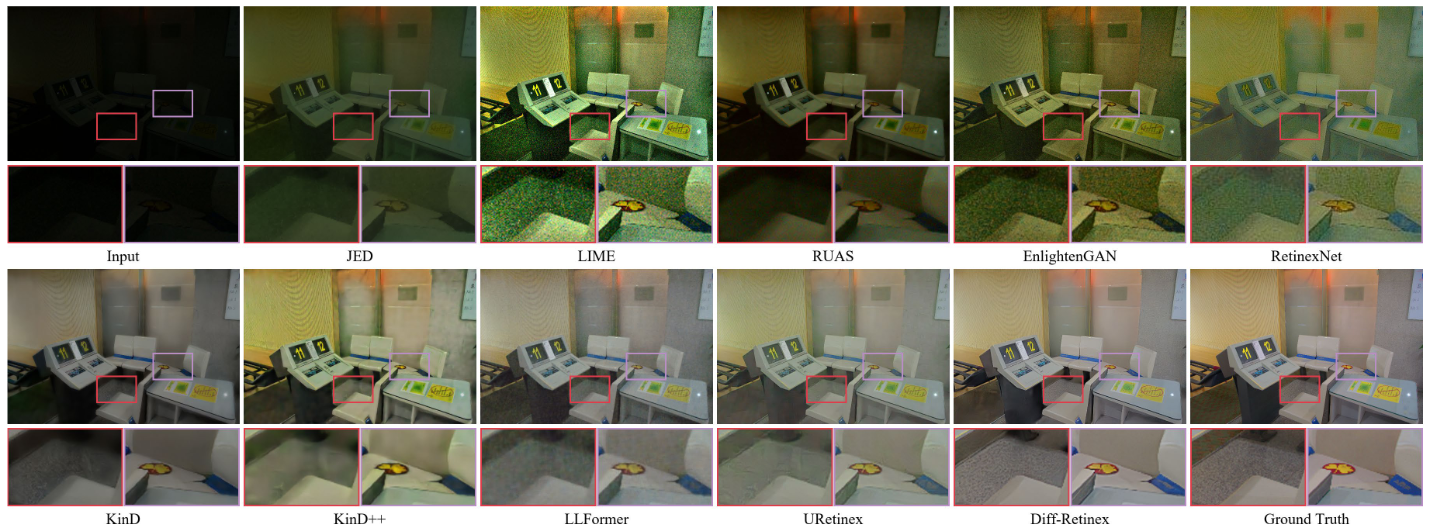

# **Process**

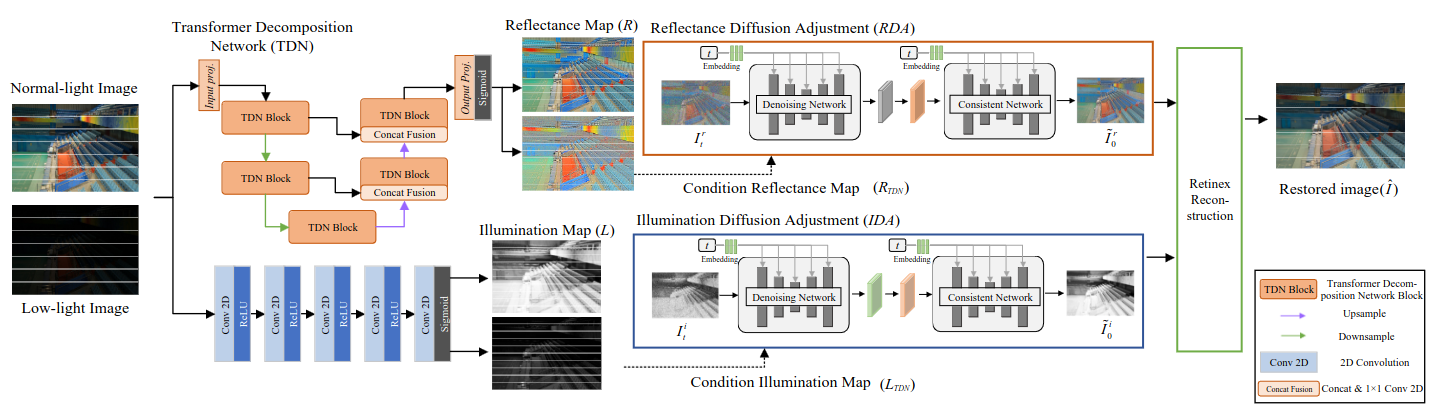

Diff-Retinex has 2 different stage. The first stage tries to decompose each image into illimunation images and reflectance images. This called as TDN Network. The second stage is a Conditional Diffusion model (SR3), in this stage model enhances the illumination image while preserving the reflectance image.


**TDN Network**

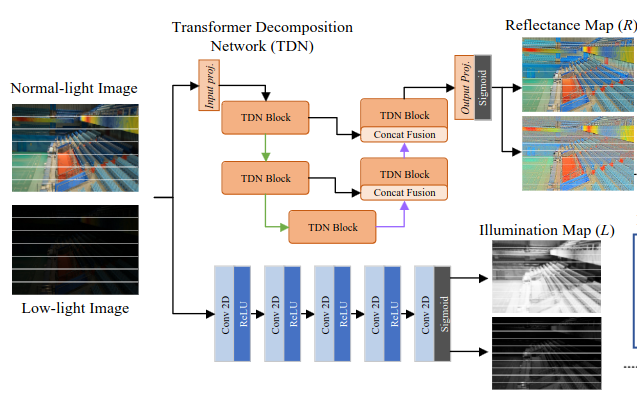

In paper, authors create a TDN network. Tansformer decomposition network (TDN) consists of two branches, the reflectance decomposition branch and the illumination decomposition branch. 
In the illumination decomposition branch, it makes up of several convolutional layers to reduce the amount of calculation on the premise of ensuring the decomposition effect.
In the reflectance decomposition branch is composed of a multi-stage Transformer encoder and decoder. Considering the high attention computing overhead in Transformer, they design a novel multi-head depth-wise convolutions layer attention (MDLA) for computing attention form in TDN.
With **Reflectance Consistency Loss**, **Reconstruction Loss** and **Illumination Smoothness Loss** these network can learn decompose each image into illimunation and reflectance images.

**Reflectance Consistency Loss:** Considering that the reflectance of objects is invariant in various lighting conditions, they constrain the consistency of reflectance maps in different lighting conditions. Specifically, It can be described as:

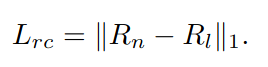


**Reconstruction Loss:** It guarantees that the decomposed Reflectance and Illumination images can reconstruct the original image.

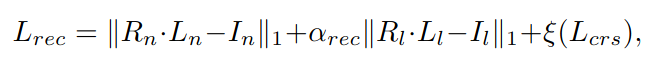

ξ(Lcrs) is an small auxiliary function for the cross multiplication of the illumination and reflection maps for low and normal light.

**Illumination Smoothness Loss:** Considering the illumination should be piece-wise smooth, they constrain it by:

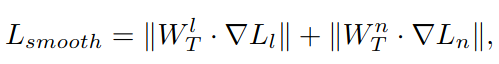

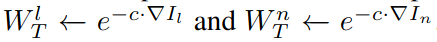

**TOTAL LOSS:** Ultimately, the overall decomposition loss is denoted as:

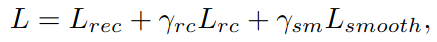

**Conditional Diffusion Network**

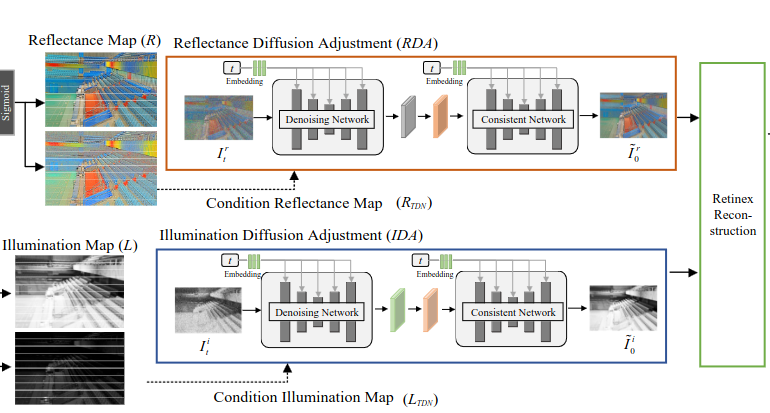

This stage refines the illumination and reflectance components separately. The paper employs a single diffusion network architecture with different weights for each refinement task. The network, based on the SR3 (Image Super-Resolution via Iterative Refinement) paper, operates in a conditional manner. It takes the low-light illumination or reflectance map from the TDN network as input and progressively enhances it.

**Reconstruction**

Finally, the enhanced illumination and reflectance maps are combined using a dot product to generate the final high-quality image.

**Qualitive Results**

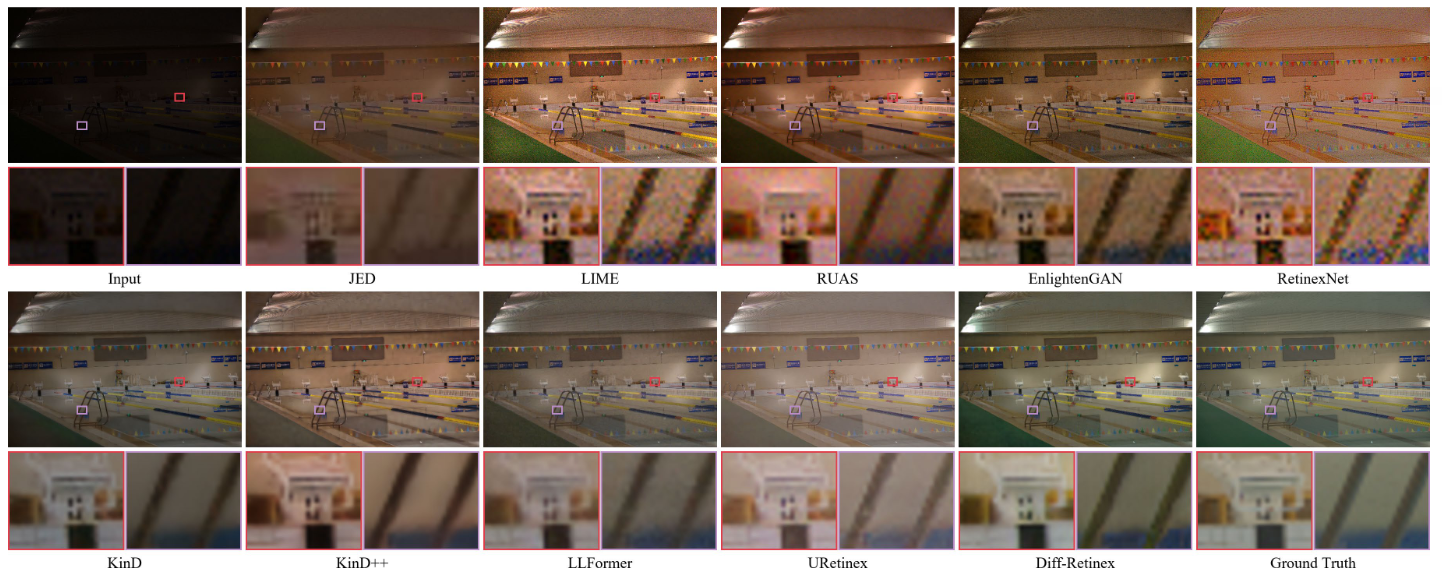

**Quantitive Results**

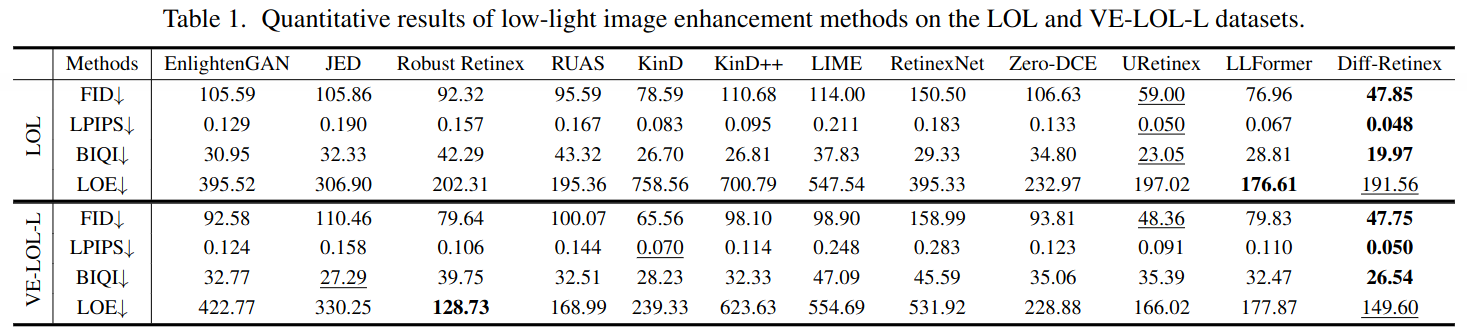


# Import the Libraries

In [ ]:
## These for Google Colab
# !chmod +x download_data.sh
# !./download_data.sh
# !mkdir lol_dataset_prosessed
# !mkdir lol_dataset_prosessed/high
# !mkdir lol_dataset_prosessed/highi
# !mkdir lol_dataset_prosessed/highr
# !mkdir lol_dataset_prosessed/low
# !mkdir lol_dataset_prosessed/lowi
# !mkdir lol_dataset_prosessed/lowr
# !pip install einops

In [ ]:
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers
import matplotlib.pyplot as plt
from einops import rearrange
from PIL import Image
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torch.nn.init as init
from datasetLoaderLol import check_images
from datasetLoaderLol import LOL_Dataset
from datasetLoaderLol import LOL_Dataset_Diffusion
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ModelTDN import TDN as TDN
import math
from diffusionModel import Denoiser
from diffusionModel import Diffusion
import zipfile
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt


# Hyperparameters

In [ ]:
SHUFFLE = False
BATCH_SIZE = 3
EPOCHS = 15
GamaRC = 0.1
GamaSM = 0.1
GamaCT = 1
AlphaRec = 0.3
lr = 0.0001


# Select Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets


In [ ]:
DATASET_TRAIN_HIGH_PATH = './lol_dataset/our485/high'
DATASET_TRAIN_LOW_PATH = './lol_dataset/our485/low'
dataset_train_high = LOL_Dataset(DATASET_TRAIN_HIGH_PATH)
dataset_train_low = LOL_Dataset(DATASET_TRAIN_LOW_PATH)
data_loader_train_high = DataLoader(dataset_train_high, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
data_loader_train_low = DataLoader(dataset_train_low, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Loss for TDN

In [ ]:
def total_loss(image_batch_low, image_batch_high,predict_low, predict_high, predict_low_ill, predict_high_ill,c):
    return GamaRC*ReflectanceConsistencyLoss(predict_low, predict_high) + RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill)
    + GamaSM*IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low_ill, predict_high_ill,c)

def ReflectanceConsistencyLoss(predict_low, predict_high):
    return torch.norm(predict_high - predict_low, p=1)

def RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill):
    return torch.norm(predict_high.to(device)*predict_high_ill - image_batch_high.to(device), p=1) + AlphaRec * torch.norm(predict_low.to(device)*predict_low_ill - image_batch_low.to(device),p=1)

def IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low, predict_high,c):
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)


    grayscale_images_low = torch.mean(image_batch_low, dim=1, keepdim=True) #[0]
    grayscale_images_low = torch.sigmoid(grayscale_images_low);
    grad_x_low = F.conv2d(grayscale_images_low, sobel_x, padding=1)
    grad_y_low = F.conv2d(grayscale_images_low, sobel_y, padding=1)
    grad_magnitude_low = torch.sqrt(grad_x_low**2 + grad_y_low**2)
    W_l = torch.exp(-c*grad_magnitude_low).to(device)


    grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grayscale_images_high = torch.sigmoid(grayscale_images_high);

    grad_x_high = F.conv2d(grayscale_images_high, sobel_x, padding=1)
    grad_y_high = F.conv2d(grayscale_images_high, sobel_y, padding=1)
    grad_magnitude_high = torch.sqrt(grad_x_high**2 + grad_y_high**2)
    W_h = torch.exp(-c*grad_magnitude_high).to(device)

    sobel_x = sobel_x.cuda()
    sobel_y = sobel_y.cuda()
    #grayscale_predict_low = torch.mean(predict_low, dim=1, keepdim=True) #[0]
    grad_x_low_predict = F.conv2d((predict_low), sobel_x, padding=1)
    grad_y_low_predict = F.conv2d((predict_low), sobel_y, padding=1)
    L_l = torch.sqrt(grad_x_low_predict**2 + grad_y_low_predict**2+ 1e-8)


    #grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grad_x_high_predict = F.conv2d((predict_high), sobel_x, padding=1)
    grad_y_high_predict = F.conv2d((predict_high), sobel_y, padding=1)
    L_h = torch.sqrt(grad_x_high_predict**2 + grad_y_high_predict**2 + 1e-8)


    return torch.norm( (W_l * L_l)) + torch.norm((W_h * L_h))




# Training TDN

In [ ]:
model = TDN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, ((data_low), (data_high)) in enumerate(zip(data_loader_train_low, data_loader_train_high)):
        optimizer.zero_grad()
        outputs_lowR,outputs_low = model(data_low.to(device))
        outputs_highR, outputs_high = model(data_high.to(device))
        loss = total_loss( data_low, data_high,outputs_lowR,outputs_highR,outputs_low,outputs_high,10)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        single_image = outputs_high[0]
        if i % 15 == 14:  # Her 100 mini-batch'de bir kaybı yazdır
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0

print('Training finished')

# Save Model


In [10]:
model_path = 'TDN.pth'
torch.save(model.state_dict(),model_path)

# Inference TDN

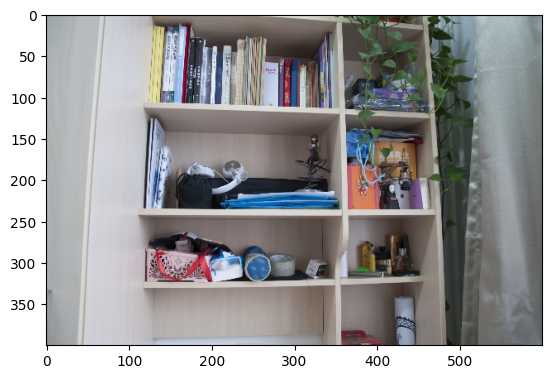

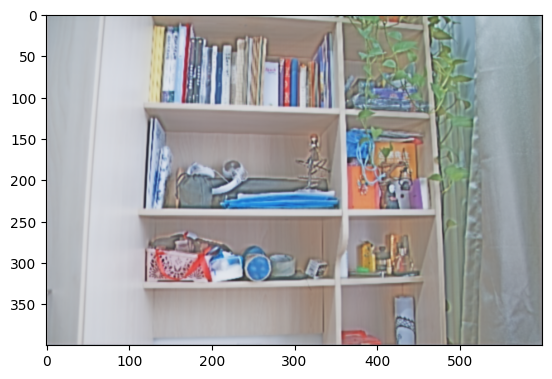

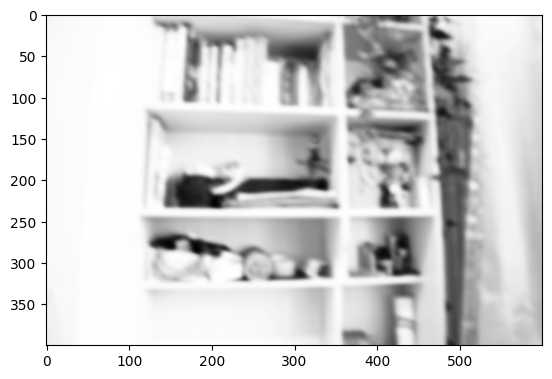

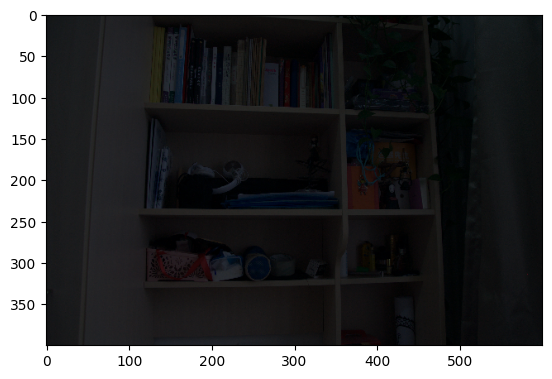

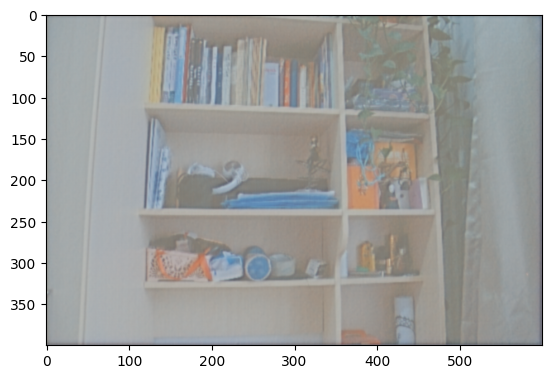

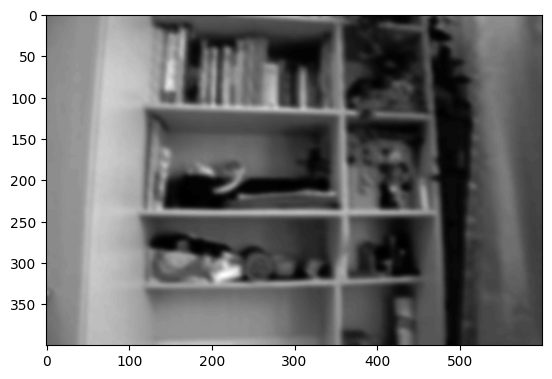

In [13]:
model = TDN().to(device)
model.load_state_dict(torch.load("TDN.pth"))

##### Prepare dataloader for inference, make batch size 1 ###########################
data_loader_train_high = DataLoader(dataset_train_high, batch_size=1, shuffle=SHUFFLE)
data_loader_train_low  = DataLoader(dataset_train_low, batch_size=1, shuffle=SHUFFLE)
#####################################################################################
with torch.no_grad():
  number_image=0
  for i in data_loader_train_high:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()

      save_path = './lol_dataset_prosessed/high/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/highr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image,cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/highi/'+str(number_image)+'.png'
      image.save(save_path)
with torch.no_grad():
  number_image=0
  for i in data_loader_train_low:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/low/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/lowr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image, cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/lowi/'+str(number_image)+'.png'
      image.save(save_path)


# Hyperparameters for Diffusion

In [14]:
torch.cuda.empty_cache()
img_size = (100, 100, 3)
timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
hidden_dims = [hidden_dim for _ in range(n_layers)]
n_timesteps = 1000
beta_minmax = [1e-4, 2e-2]
lr = 5e-5
batch_size = 64
num_epochs = 800


# Model for Diffusion


In [15]:

model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps).to(device)

diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=device).to(device)

# Loss and Optimizer for Diffusion

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

# Dataloader for Diffusion

In [17]:


# Define your dataset and DataLoader for high light reflectance images
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Define your dataset and DataLoader for high light reflectance images
dataset = LOL_Dataset_Diffusion('./lol_dataset_prosessed/highr', './lol_dataset_prosessed/lowr', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


# Train and Inference

Start training DDPMs...
	Epoch 1 complete! 	Denoising Loss:  0.9789853170514107
	Epoch 2 complete! 	Denoising Loss:  0.6786638274788857
	Epoch 3 complete! 	Denoising Loss:  0.4732278510928154
	Epoch 4 complete! 	Denoising Loss:  0.31558066606521606
	Epoch 5 complete! 	Denoising Loss:  0.22967075929045677
	Epoch 6 complete! 	Denoising Loss:  0.17670167610049248
	Epoch 7 complete! 	Denoising Loss:  0.16235701460391283
	Epoch 8 complete! 	Denoising Loss:  0.13184182345867157
	Epoch 9 complete! 	Denoising Loss:  0.1261353213340044
	Epoch 10 complete! 	Denoising Loss:  0.09292934648692608


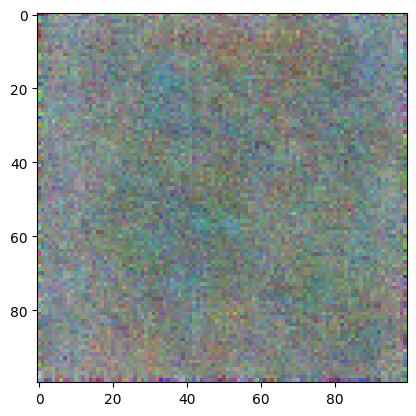

	Epoch 11 complete! 	Denoising Loss:  0.10096970107406378
	Epoch 12 complete! 	Denoising Loss:  0.10244299098849297
	Epoch 13 complete! 	Denoising Loss:  0.08544851373881102
	Epoch 14 complete! 	Denoising Loss:  0.07754241395741701
	Epoch 15 complete! 	Denoising Loss:  0.08027603570371866
	Epoch 16 complete! 	Denoising Loss:  0.0763602708466351
	Epoch 17 complete! 	Denoising Loss:  0.07184174982830882
	Epoch 18 complete! 	Denoising Loss:  0.0868674349039793
	Epoch 19 complete! 	Denoising Loss:  0.0657988260500133
	Epoch 20 complete! 	Denoising Loss:  0.06398443691432476


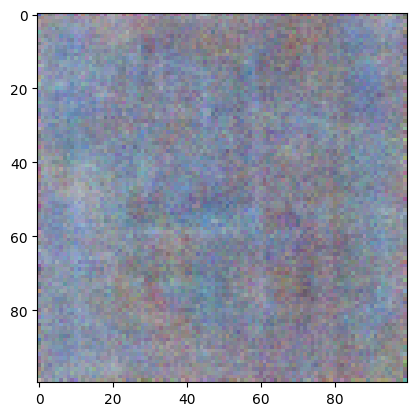

	Epoch 21 complete! 	Denoising Loss:  0.06483056861907244
	Epoch 22 complete! 	Denoising Loss:  0.05923786759376526
	Epoch 23 complete! 	Denoising Loss:  0.06532941106706858
	Epoch 24 complete! 	Denoising Loss:  0.07050673710182309
	Epoch 25 complete! 	Denoising Loss:  0.050408107694238424
	Epoch 26 complete! 	Denoising Loss:  0.051273738499730825
	Epoch 27 complete! 	Denoising Loss:  0.05239093769341707
	Epoch 28 complete! 	Denoising Loss:  0.04829120170325041
	Epoch 29 complete! 	Denoising Loss:  0.04777043266221881
	Epoch 30 complete! 	Denoising Loss:  0.042274991516023874


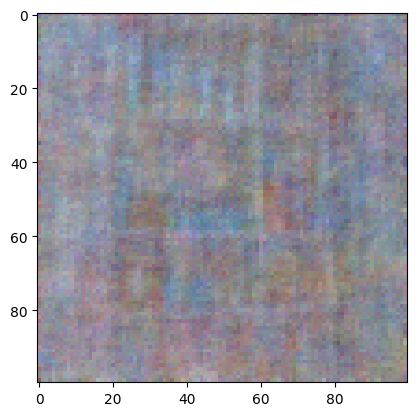

	Epoch 31 complete! 	Denoising Loss:  0.04583241976797581
	Epoch 32 complete! 	Denoising Loss:  0.05657522566616535
	Epoch 33 complete! 	Denoising Loss:  0.04559945687651634
	Epoch 34 complete! 	Denoising Loss:  0.04726992920041084
	Epoch 35 complete! 	Denoising Loss:  0.038225723430514336
	Epoch 36 complete! 	Denoising Loss:  0.052244162652641535
	Epoch 37 complete! 	Denoising Loss:  0.05411782022565603
	Epoch 38 complete! 	Denoising Loss:  0.051442261785268784
	Epoch 39 complete! 	Denoising Loss:  0.04319506138563156
	Epoch 40 complete! 	Denoising Loss:  0.04656340414658189


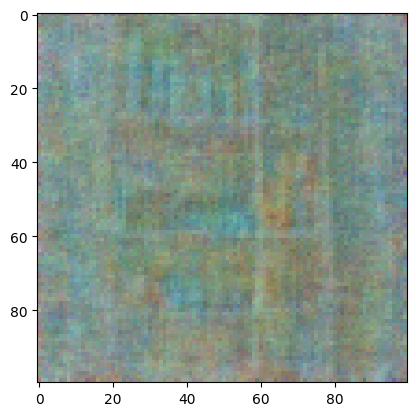

	Epoch 41 complete! 	Denoising Loss:  0.04405510728247464
	Epoch 42 complete! 	Denoising Loss:  0.038276124745607376
	Epoch 43 complete! 	Denoising Loss:  0.04234195174649358
	Epoch 44 complete! 	Denoising Loss:  0.03708101762458682
	Epoch 45 complete! 	Denoising Loss:  0.04339169920422137
	Epoch 46 complete! 	Denoising Loss:  0.04411220131441951
	Epoch 47 complete! 	Denoising Loss:  0.0393763838801533
	Epoch 48 complete! 	Denoising Loss:  0.04237849172204733
	Epoch 49 complete! 	Denoising Loss:  0.041439195862039924
	Epoch 50 complete! 	Denoising Loss:  0.03959453688003123


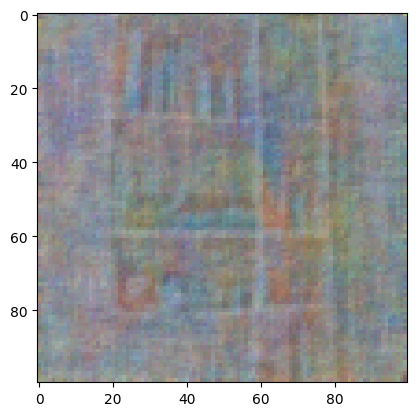

	Epoch 51 complete! 	Denoising Loss:  0.04126004269346595
	Epoch 52 complete! 	Denoising Loss:  0.03525026794523001
	Epoch 53 complete! 	Denoising Loss:  0.0489240912720561
	Epoch 54 complete! 	Denoising Loss:  0.04080328019335866
	Epoch 55 complete! 	Denoising Loss:  0.047214129008352757
	Epoch 56 complete! 	Denoising Loss:  0.043852003989741206
	Epoch 57 complete! 	Denoising Loss:  0.03959429310634732
	Epoch 58 complete! 	Denoising Loss:  0.036196351051330566
	Epoch 59 complete! 	Denoising Loss:  0.03844103426672518
	Epoch 60 complete! 	Denoising Loss:  0.0354443877004087


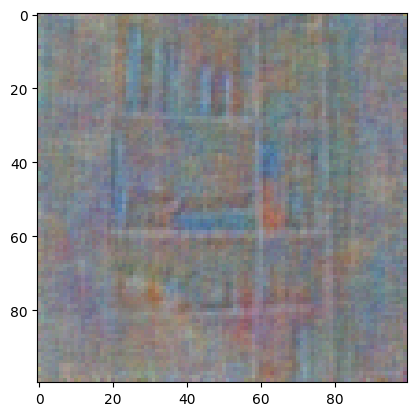

	Epoch 61 complete! 	Denoising Loss:  0.031872134655714035
	Epoch 62 complete! 	Denoising Loss:  0.033311976585537195
	Epoch 63 complete! 	Denoising Loss:  0.035258250776678324
	Epoch 64 complete! 	Denoising Loss:  0.034735969733446836
	Epoch 65 complete! 	Denoising Loss:  0.03236498194746673
	Epoch 66 complete! 	Denoising Loss:  0.041191291296854615
	Epoch 67 complete! 	Denoising Loss:  0.03410998056642711
	Epoch 68 complete! 	Denoising Loss:  0.0289373523555696
	Epoch 69 complete! 	Denoising Loss:  0.040040346793830395
	Epoch 70 complete! 	Denoising Loss:  0.038714409340173006


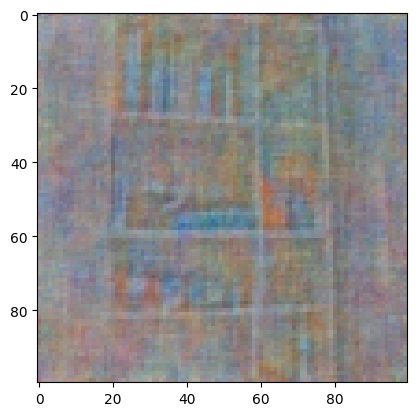

	Epoch 71 complete! 	Denoising Loss:  0.02994738705456257
	Epoch 72 complete! 	Denoising Loss:  0.03515623020939529
	Epoch 73 complete! 	Denoising Loss:  0.04054695344530046
	Epoch 74 complete! 	Denoising Loss:  0.04208963317796588
	Epoch 75 complete! 	Denoising Loss:  0.03549490589648485
	Epoch 76 complete! 	Denoising Loss:  0.03864543652161956
	Epoch 77 complete! 	Denoising Loss:  0.03051368100568652
	Epoch 78 complete! 	Denoising Loss:  0.028212480014190078
	Epoch 79 complete! 	Denoising Loss:  0.03915115958079696
	Epoch 80 complete! 	Denoising Loss:  0.028968339320272207


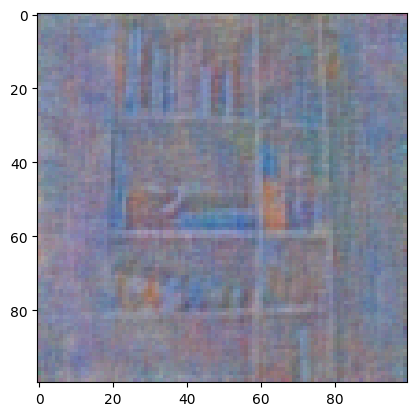

	Epoch 81 complete! 	Denoising Loss:  0.03723495942540467
	Epoch 82 complete! 	Denoising Loss:  0.03074499568901956
	Epoch 83 complete! 	Denoising Loss:  0.033280789852142334
	Epoch 84 complete! 	Denoising Loss:  0.02668577479198575
	Epoch 85 complete! 	Denoising Loss:  0.03183676558546722
	Epoch 86 complete! 	Denoising Loss:  0.03311750805005431
	Epoch 87 complete! 	Denoising Loss:  0.03399382019415498
	Epoch 88 complete! 	Denoising Loss:  0.03136965609155595
	Epoch 89 complete! 	Denoising Loss:  0.03293063654564321
	Epoch 90 complete! 	Denoising Loss:  0.034243250265717506


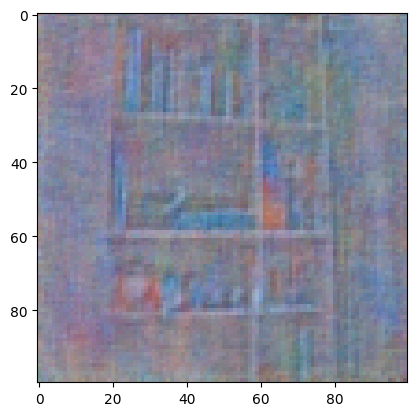

	Epoch 91 complete! 	Denoising Loss:  0.030958174960687757
	Epoch 92 complete! 	Denoising Loss:  0.033063050359487534
	Epoch 93 complete! 	Denoising Loss:  0.027414821553975344
	Epoch 94 complete! 	Denoising Loss:  0.025480968412011862
	Epoch 95 complete! 	Denoising Loss:  0.024980278685688972
	Epoch 96 complete! 	Denoising Loss:  0.02939314558170736
	Epoch 97 complete! 	Denoising Loss:  0.03220557468011975
	Epoch 98 complete! 	Denoising Loss:  0.025695392629131675
	Epoch 99 complete! 	Denoising Loss:  0.03481542528606951
	Epoch 100 complete! 	Denoising Loss:  0.0251406691968441


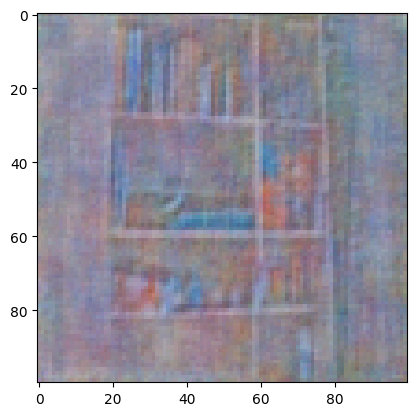

	Epoch 101 complete! 	Denoising Loss:  0.03284855093806982
	Epoch 102 complete! 	Denoising Loss:  0.027477384544909
	Epoch 103 complete! 	Denoising Loss:  0.02581074251793325
	Epoch 104 complete! 	Denoising Loss:  0.030761135276407003
	Epoch 105 complete! 	Denoising Loss:  0.030164025723934174
	Epoch 106 complete! 	Denoising Loss:  0.026407819357700646
	Epoch 107 complete! 	Denoising Loss:  0.02977175172418356
	Epoch 108 complete! 	Denoising Loss:  0.027493242756463587
	Epoch 109 complete! 	Denoising Loss:  0.028063199017196894
	Epoch 110 complete! 	Denoising Loss:  0.027535699191503227


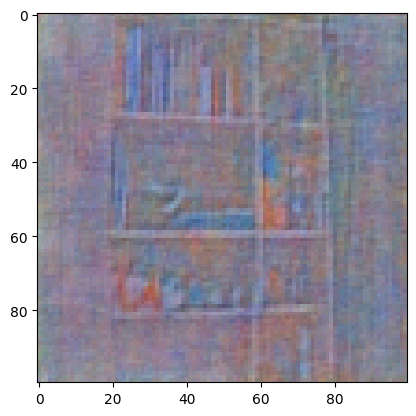

	Epoch 111 complete! 	Denoising Loss:  0.029387906892225146
	Epoch 112 complete! 	Denoising Loss:  0.028908220352604985
	Epoch 113 complete! 	Denoising Loss:  0.026815920835360885
	Epoch 114 complete! 	Denoising Loss:  0.021180442068725824
	Epoch 115 complete! 	Denoising Loss:  0.02459914213977754
	Epoch 116 complete! 	Denoising Loss:  0.030046064173802733
	Epoch 117 complete! 	Denoising Loss:  0.03239239868707955
	Epoch 118 complete! 	Denoising Loss:  0.030108652776107192
	Epoch 119 complete! 	Denoising Loss:  0.02864129119552672
	Epoch 120 complete! 	Denoising Loss:  0.028295932104811072


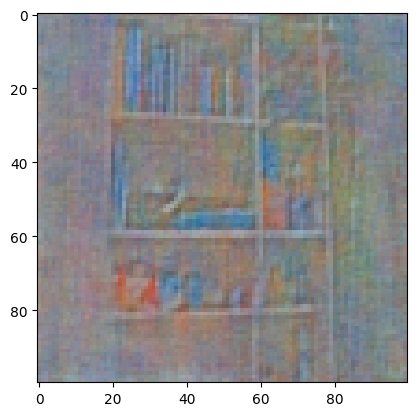

	Epoch 121 complete! 	Denoising Loss:  0.020820214063860476
	Epoch 122 complete! 	Denoising Loss:  0.025175209855660796
	Epoch 123 complete! 	Denoising Loss:  0.02589408098720014
	Epoch 124 complete! 	Denoising Loss:  0.0223457490792498
	Epoch 125 complete! 	Denoising Loss:  0.028069431893527508
	Epoch 126 complete! 	Denoising Loss:  0.02783244289457798
	Epoch 127 complete! 	Denoising Loss:  0.02488649298902601
	Epoch 128 complete! 	Denoising Loss:  0.03141162102110684
	Epoch 129 complete! 	Denoising Loss:  0.02485055278521031
	Epoch 130 complete! 	Denoising Loss:  0.0271740450989455


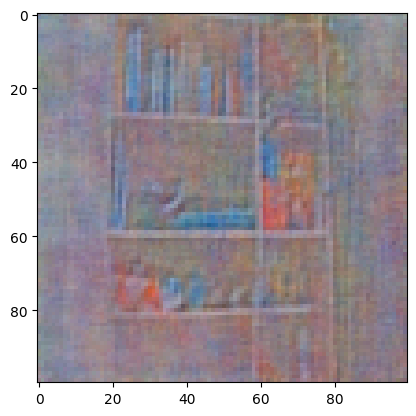

	Epoch 131 complete! 	Denoising Loss:  0.024595546768978238
	Epoch 132 complete! 	Denoising Loss:  0.0215846779756248
	Epoch 133 complete! 	Denoising Loss:  0.028019997291266918
	Epoch 134 complete! 	Denoising Loss:  0.029916874133050442
	Epoch 135 complete! 	Denoising Loss:  0.02417674206662923
	Epoch 136 complete! 	Denoising Loss:  0.020531557383947074
	Epoch 137 complete! 	Denoising Loss:  0.022156405495479703
	Epoch 138 complete! 	Denoising Loss:  0.024859238881617785
	Epoch 139 complete! 	Denoising Loss:  0.023892753990367055
	Epoch 140 complete! 	Denoising Loss:  0.027655567857436836


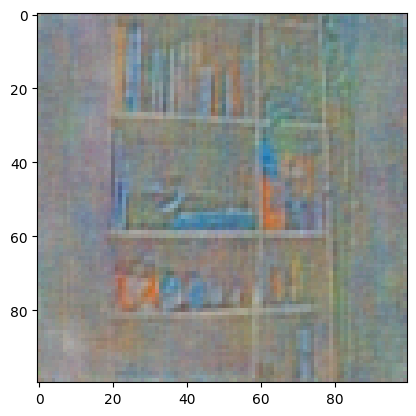

	Epoch 141 complete! 	Denoising Loss:  0.022585678147152066
	Epoch 142 complete! 	Denoising Loss:  0.025408842135220766
	Epoch 143 complete! 	Denoising Loss:  0.024344248580746353
	Epoch 144 complete! 	Denoising Loss:  0.023864009068347514
	Epoch 145 complete! 	Denoising Loss:  0.025480499025434256
	Epoch 146 complete! 	Denoising Loss:  0.026500828796997666
	Epoch 147 complete! 	Denoising Loss:  0.021357453195378184
	Epoch 148 complete! 	Denoising Loss:  0.02847649878822267
	Epoch 149 complete! 	Denoising Loss:  0.03256845835130662
	Epoch 150 complete! 	Denoising Loss:  0.018951170961372554


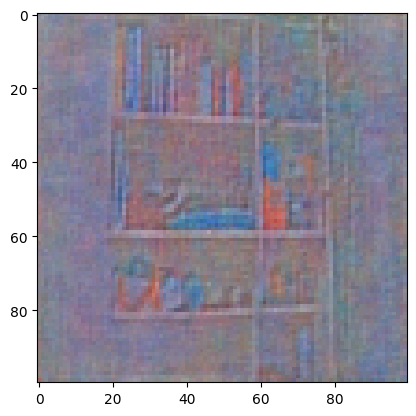

	Epoch 151 complete! 	Denoising Loss:  0.021379015874117613
	Epoch 152 complete! 	Denoising Loss:  0.02425701729953289
	Epoch 153 complete! 	Denoising Loss:  0.025258063338696957
	Epoch 154 complete! 	Denoising Loss:  0.024808884714730084
	Epoch 155 complete! 	Denoising Loss:  0.025955921737477183
	Epoch 156 complete! 	Denoising Loss:  0.024333396111615002
	Epoch 157 complete! 	Denoising Loss:  0.024980018381029367
	Epoch 158 complete! 	Denoising Loss:  0.0229234000435099
	Epoch 159 complete! 	Denoising Loss:  0.02609725366346538
	Epoch 160 complete! 	Denoising Loss:  0.020167483016848564


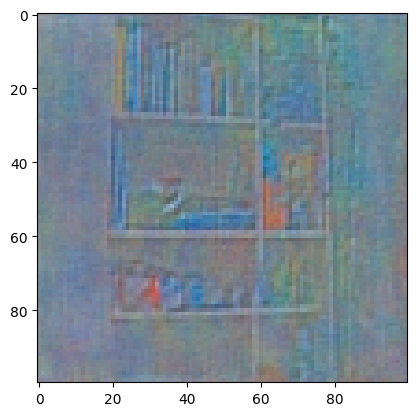

	Epoch 161 complete! 	Denoising Loss:  0.02247225889004767
	Epoch 162 complete! 	Denoising Loss:  0.025084410328418016
	Epoch 163 complete! 	Denoising Loss:  0.022758794017136097
	Epoch 164 complete! 	Denoising Loss:  0.022452154255006462
	Epoch 165 complete! 	Denoising Loss:  0.020308054401539266
	Epoch 166 complete! 	Denoising Loss:  0.021677630837075412
	Epoch 167 complete! 	Denoising Loss:  0.018489236827008426
	Epoch 168 complete! 	Denoising Loss:  0.016550408327020705
	Epoch 169 complete! 	Denoising Loss:  0.02086792595218867
	Epoch 170 complete! 	Denoising Loss:  0.018399266060441732


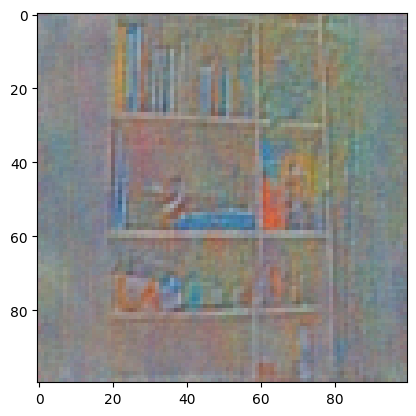

	Epoch 171 complete! 	Denoising Loss:  0.023602966219186783
	Epoch 172 complete! 	Denoising Loss:  0.02262854005675763
	Epoch 173 complete! 	Denoising Loss:  0.027327883057296276
	Epoch 174 complete! 	Denoising Loss:  0.020675034262239933
	Epoch 175 complete! 	Denoising Loss:  0.02215470012743026
	Epoch 176 complete! 	Denoising Loss:  0.024231908028014004
	Epoch 177 complete! 	Denoising Loss:  0.017604508087970316
	Epoch 178 complete! 	Denoising Loss:  0.022968765115365386
	Epoch 179 complete! 	Denoising Loss:  0.02079508814495057
	Epoch 180 complete! 	Denoising Loss:  0.025910117314197123


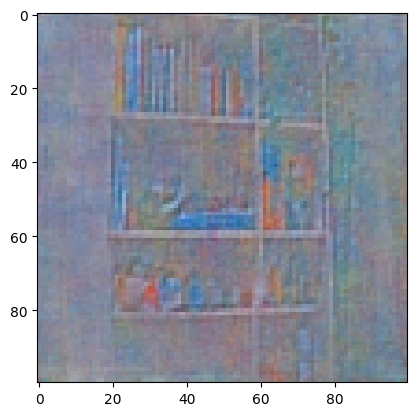

	Epoch 181 complete! 	Denoising Loss:  0.022404186078347266
	Epoch 182 complete! 	Denoising Loss:  0.024733743746764958
	Epoch 183 complete! 	Denoising Loss:  0.023227018769830465
	Epoch 184 complete! 	Denoising Loss:  0.01970823050942272
	Epoch 185 complete! 	Denoising Loss:  0.019706863909959793
	Epoch 186 complete! 	Denoising Loss:  0.02254600333981216
	Epoch 187 complete! 	Denoising Loss:  0.017528578406199813
	Epoch 188 complete! 	Denoising Loss:  0.020491359056904912
	Epoch 189 complete! 	Denoising Loss:  0.02051941805984825
	Epoch 190 complete! 	Denoising Loss:  0.022837037802673876


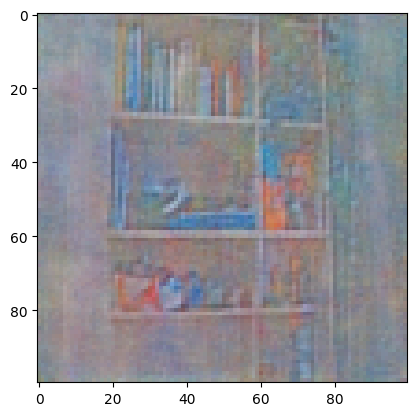

	Epoch 191 complete! 	Denoising Loss:  0.023190477397292852
	Epoch 192 complete! 	Denoising Loss:  0.02221709256991744
	Epoch 193 complete! 	Denoising Loss:  0.024425202165730298
	Epoch 194 complete! 	Denoising Loss:  0.01861420040950179
	Epoch 195 complete! 	Denoising Loss:  0.018134051584638655
	Epoch 196 complete! 	Denoising Loss:  0.021353255142457783
	Epoch 197 complete! 	Denoising Loss:  0.026587799307890236
	Epoch 198 complete! 	Denoising Loss:  0.021537556895054877
	Epoch 199 complete! 	Denoising Loss:  0.01873468980193138
	Epoch 200 complete! 	Denoising Loss:  0.0186252782586962


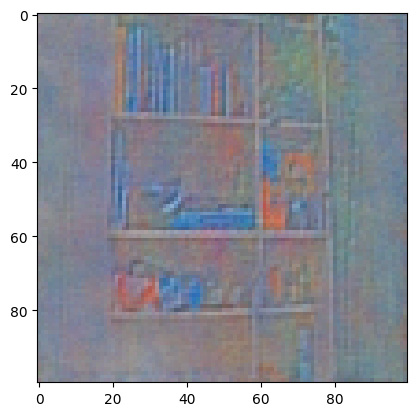

	Epoch 201 complete! 	Denoising Loss:  0.019537073909305036
	Epoch 202 complete! 	Denoising Loss:  0.016914433101192117
	Epoch 203 complete! 	Denoising Loss:  0.016354155843146145
	Epoch 204 complete! 	Denoising Loss:  0.019561739754863083
	Epoch 205 complete! 	Denoising Loss:  0.019848642987199128
	Epoch 206 complete! 	Denoising Loss:  0.017125688842497766
	Epoch 207 complete! 	Denoising Loss:  0.02768273907713592
	Epoch 208 complete! 	Denoising Loss:  0.01780455478001386
	Epoch 209 complete! 	Denoising Loss:  0.01902237080503255
	Epoch 210 complete! 	Denoising Loss:  0.01619452447630465


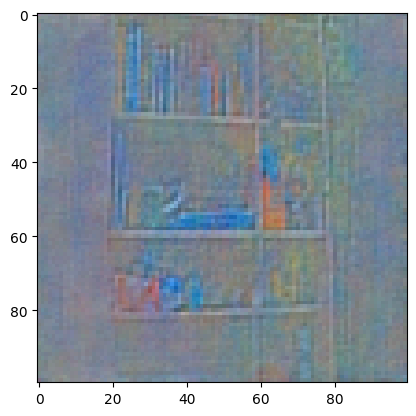

	Epoch 211 complete! 	Denoising Loss:  0.019631741801276803
	Epoch 212 complete! 	Denoising Loss:  0.02445778565015644
	Epoch 213 complete! 	Denoising Loss:  0.029493964044377208
	Epoch 214 complete! 	Denoising Loss:  0.019266057410277426
	Epoch 215 complete! 	Denoising Loss:  0.016447777510620654
	Epoch 216 complete! 	Denoising Loss:  0.024101337883621454
	Epoch 217 complete! 	Denoising Loss:  0.021419689641334116
	Epoch 218 complete! 	Denoising Loss:  0.01890100189484656
	Epoch 219 complete! 	Denoising Loss:  0.015674683381803334
	Epoch 220 complete! 	Denoising Loss:  0.02387013379484415


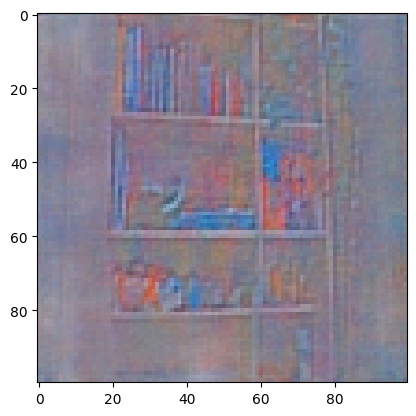

	Epoch 221 complete! 	Denoising Loss:  0.021361179067753255
	Epoch 222 complete! 	Denoising Loss:  0.02212232304736972
	Epoch 223 complete! 	Denoising Loss:  0.01726730540394783
	Epoch 224 complete! 	Denoising Loss:  0.01840452558826655
	Epoch 225 complete! 	Denoising Loss:  0.018859125848393887
	Epoch 226 complete! 	Denoising Loss:  0.020548714324831963
	Epoch 227 complete! 	Denoising Loss:  0.02098827890586108
	Epoch 228 complete! 	Denoising Loss:  0.023184980964288116
	Epoch 229 complete! 	Denoising Loss:  0.02139102213550359
	Epoch 230 complete! 	Denoising Loss:  0.024614212685264647


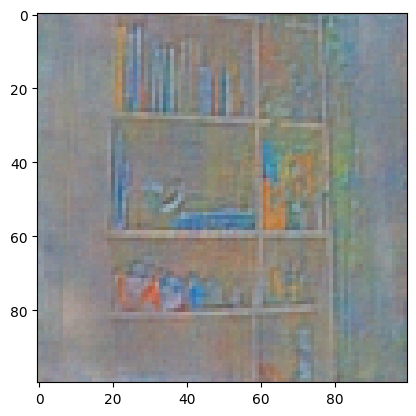

	Epoch 231 complete! 	Denoising Loss:  0.021430722437798977
	Epoch 232 complete! 	Denoising Loss:  0.017026086803525686
	Epoch 233 complete! 	Denoising Loss:  0.019834825419820845
	Epoch 234 complete! 	Denoising Loss:  0.026125259581021965
	Epoch 235 complete! 	Denoising Loss:  0.01935809280257672
	Epoch 236 complete! 	Denoising Loss:  0.020700840977951884
	Epoch 237 complete! 	Denoising Loss:  0.017706547398120165
	Epoch 238 complete! 	Denoising Loss:  0.018459212384186685
	Epoch 239 complete! 	Denoising Loss:  0.019678155076690018
	Epoch 240 complete! 	Denoising Loss:  0.01710273849312216


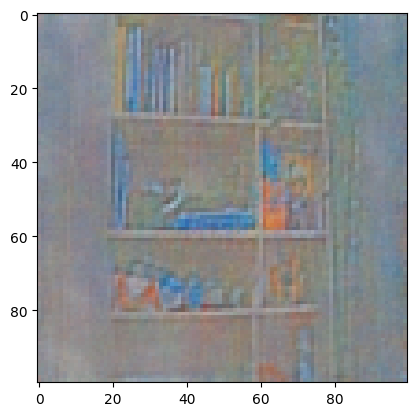

	Epoch 241 complete! 	Denoising Loss:  0.020509446156211197
	Epoch 242 complete! 	Denoising Loss:  0.01880211103707552
	Epoch 243 complete! 	Denoising Loss:  0.019519058405421674
	Epoch 244 complete! 	Denoising Loss:  0.020771564100869
	Epoch 245 complete! 	Denoising Loss:  0.018346665194258094
	Epoch 246 complete! 	Denoising Loss:  0.01624377758707851
	Epoch 247 complete! 	Denoising Loss:  0.016989408642984927
	Epoch 248 complete! 	Denoising Loss:  0.020060773356817663
	Epoch 249 complete! 	Denoising Loss:  0.02128236717544496
	Epoch 250 complete! 	Denoising Loss:  0.019433287903666496


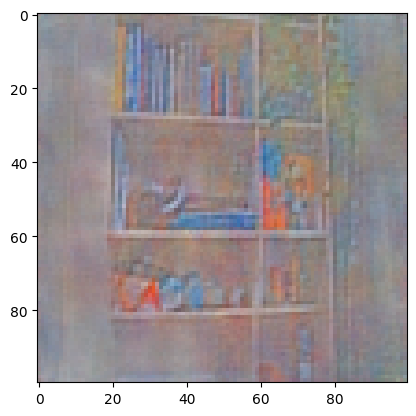

	Epoch 251 complete! 	Denoising Loss:  0.017777825822122395
	Epoch 252 complete! 	Denoising Loss:  0.02278457337524742
	Epoch 253 complete! 	Denoising Loss:  0.022134621860459447
	Epoch 254 complete! 	Denoising Loss:  0.020553865004330873
	Epoch 255 complete! 	Denoising Loss:  0.021227541379630566
	Epoch 256 complete! 	Denoising Loss:  0.021557759260758758
	Epoch 257 complete! 	Denoising Loss:  0.017811024910770357
	Epoch 258 complete! 	Denoising Loss:  0.019446993246674538
	Epoch 259 complete! 	Denoising Loss:  0.01456594851333648
	Epoch 260 complete! 	Denoising Loss:  0.017166701843962073


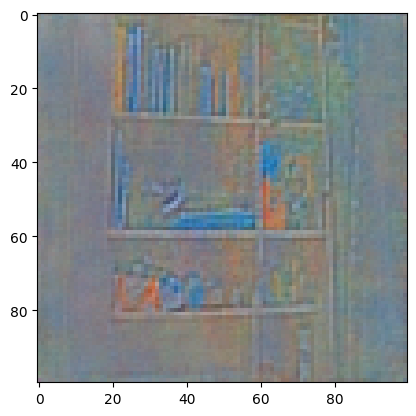

	Epoch 261 complete! 	Denoising Loss:  0.016311969025991857
	Epoch 262 complete! 	Denoising Loss:  0.020118625892791897
	Epoch 263 complete! 	Denoising Loss:  0.019563435693271458
	Epoch 264 complete! 	Denoising Loss:  0.017839644569903612
	Epoch 265 complete! 	Denoising Loss:  0.01766460487851873
	Epoch 266 complete! 	Denoising Loss:  0.019508764205966145
	Epoch 267 complete! 	Denoising Loss:  0.029364727321080863
	Epoch 268 complete! 	Denoising Loss:  0.014619302412029356
	Epoch 269 complete! 	Denoising Loss:  0.018435280537232757
	Epoch 270 complete! 	Denoising Loss:  0.018907626799773425


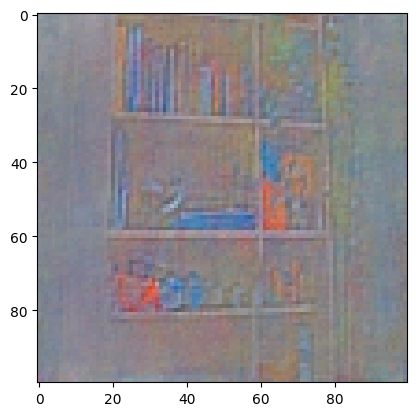

	Epoch 271 complete! 	Denoising Loss:  0.01641922304406762
	Epoch 272 complete! 	Denoising Loss:  0.018829700420610607
	Epoch 273 complete! 	Denoising Loss:  0.01733606110792607
	Epoch 274 complete! 	Denoising Loss:  0.01634492864832282
	Epoch 275 complete! 	Denoising Loss:  0.014640120440162718
	Epoch 276 complete! 	Denoising Loss:  0.019448294071480632
	Epoch 277 complete! 	Denoising Loss:  0.019213150022551417
	Epoch 278 complete! 	Denoising Loss:  0.01622512168250978
	Epoch 279 complete! 	Denoising Loss:  0.01947140006814152
	Epoch 280 complete! 	Denoising Loss:  0.019038985192310065


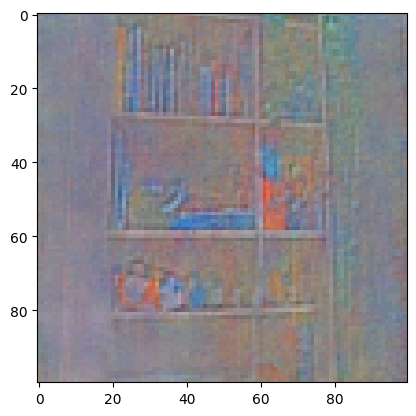

	Epoch 281 complete! 	Denoising Loss:  0.02396031387615949
	Epoch 282 complete! 	Denoising Loss:  0.017117011710070074
	Epoch 283 complete! 	Denoising Loss:  0.014307461096905172
	Epoch 284 complete! 	Denoising Loss:  0.022719510132446885
	Epoch 285 complete! 	Denoising Loss:  0.01730589452199638
	Epoch 286 complete! 	Denoising Loss:  0.014317538239993155
	Epoch 287 complete! 	Denoising Loss:  0.021166694350540638
	Epoch 288 complete! 	Denoising Loss:  0.017207478755153716
	Epoch 289 complete! 	Denoising Loss:  0.013936228468082845
	Epoch 290 complete! 	Denoising Loss:  0.018624808115419


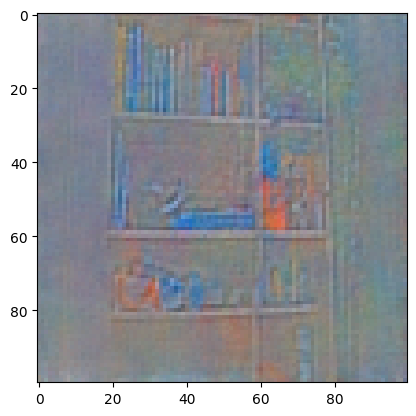

	Epoch 291 complete! 	Denoising Loss:  0.017219310044310987
	Epoch 292 complete! 	Denoising Loss:  0.022262107580900192


In [ ]:

print("Start training DDPMs...")
model.train()

for epoch in range(num_epochs):
    noise_prediction_loss = 0
    for batch_idx, (high_reflectance, low_reflectance) in enumerate(dataloader):
        optimizer.zero_grad()

        x = high_reflectance
        low_reflectance = low_reflectance.to(device)
        x = x.to(device)

        noisy_input, epsilon, pred_epsilon = diffusion(x, low_reflectance)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / (batch_idx+1))

    if (epoch+1) % 10 == 0 and epoch != 0:
        model.eval()
        inference_batch_size = 1
        low_reflectance = './lol_dataset_prosessed/lowr/1.png'
        # Load the image from file
        low_reflectance_img = Image.open(low_reflectance)

        # Convert the image to a tensor
        transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor()
        ])
        low_reflectance_tensor = transform(low_reflectance_img).unsqueeze(0).to(device)  # Add batch dimension

        # Now, pass the tensor to the model
        with torch.no_grad():
            generated_images = diffusion.sample(inference_batch_size, low_reflectance_tensor)

        def show_image(x, idx):
            fig = plt.figure()
            plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

        show_image(generated_images, idx=0)

        plt.imshow(generated_images[0].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
        plt.show()

    if (epoch+1) % 100 == 0 and epoch != 0:
        # Save the trained model
        model_path = f'diffusion_model_epoch_{epoch+1}.pth'
        torch.save(diffusion.state_dict(), model_path)

print("Finish!!")

# Save the trained model
torch.save(diffusion.state_dict(), 'diffusion_model.pth')
print("Model saved as diffusion_model.pth")


# Future work for diffusion

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# %cd /content/drive/MyDrive/Image-Super-Resolution-via-Iterative-Refinement

In [ ]:
# !pip install -r requirement.txt

In [ ]:
# !python sr.py -p train -c config/sr_sr3_64_512.json

In [ ]:
# !python sr.py -p val -c config/sr_sr3_64_512.json

In [ ]:
# !python infer.py -c config/sr_sr3_64_512.json